**Tutorial # 4 - Unsupervised abnormality detection**

Goals:

1.   Train an autoencoder in an unsupervised fashion with 'normal' cases
2.   Test on 'abnormal' case to determine whether normality was learnt
3.   Are there any other strategies to detect abnormalities?

**Import libraries**

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

**Define parameters**

In [ ]:
# dataset parameters
FNAME_PATTERN = 'drive/MyDrive/iSeg2019-Training/subject-{}-{}.hdr'
N_VOLUMES = 10
IMAGE_SIZE = (144, 192, 256)

# network parameters
N_CLASSES = 1
N_INPUT_CHANNELS = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)

# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6]
VALIDATION_VOLUMES = [7, 9]

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 20
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'MSE'

**Mount drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Define SegNet architecture**

In [ ]:
def get_segnet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)
    drop1 = layers.Dropout(rate=0.3)(max1, training=True)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(drop1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)
    drop2 = layers.Dropout(rate=0.3)(max2, training=True)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(drop2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)
    drop3 = layers.Dropout(rate=0.3)(max3, training=True)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(drop3)
    drop4 = layers.Dropout(rate=0.3)(lat, training=True)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(drop4)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(up1)
    drop5 = layers.Dropout(rate=0.3)(conv4, training=True)
    
    up2 = layers.UpSampling2D((2, 2))(drop5)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(up2)
    drop6 = layers.Dropout(rate=0.3)(conv5, training=True)
    
    up3 = layers.UpSampling2D((2, 2))(drop6)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(up3)
    drop7 = layers.Dropout(rate=0.3)(conv6, training=True)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="linear")(drop7)

    model = keras.Model(inputs, outputs)

    return model

**Load data**

In [ ]:
def load_data(n_volumes=N_VOLUMES, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  T2_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  for i in range(n_volumes) :
    img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    T1_volumes[i] = img_data.get_fdata()

    img_data = nib.load(fname_pattern.format(i+1, 'T2'))
    T2_volumes[i] = img_data.get_fdata()

    seg_data = nib.load(fname_pattern.format(i+1, 'label'))
    labels[i] = seg_data.get_fdata()

  return (T1_volumes, T2_volumes, labels)

In [ ]:
(T1_volumes, _, labels) = load_data()

**Split into training, validation and testing**

In [ ]:
training_volumes_T1 = T1_volumes[TRAINING_VOLUMES]
training_labels = labels[TRAINING_VOLUMES]

validation_volumes_T1 = T1_volumes[VALIDATION_VOLUMES]
validation_labels = labels[VALIDATION_VOLUMES]

**Pre-process data**

In [ ]:
def z_score_standardisation(x, avg, std):
  return (x-avg)/std

ref_avg = training_volumes_T1[training_labels!=0].mean()
ref_std = training_volumes_T1[training_labels!=0].std()

training_volumes_T1 = z_score_standardisation(training_volumes_T1, ref_avg, ref_std)
validation_volumes_T1 = z_score_standardisation(validation_volumes_T1, ref_avg, ref_std)

**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [ ]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  
  return vol_patches

In [ ]:
# extract patches from training set
training_patches_T1 = extract_useful_patches(training_volumes_T1, training_labels)

# extract patches from validation set
validation_patches_T1 = extract_useful_patches(validation_volumes_T1, validation_labels)

**Train network**

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN)
]

segnet = get_segnet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.fit(
    x=training_patches_T1,
    y=training_patches_T1,
    validation_data=(validation_patches_T1, validation_patches_T1),
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/100
213/213 [==============================] - 11s 12ms/step - loss: 0.4471 - val_loss: 0.2044
Epoch 2/100
213/213 [==============================] - 2s 9ms/step - loss: 0.2621 - val_loss: 0.1720
Epoch 3/100
213/213 [==============================] - 2s 9ms/step - loss: 0.2307 - val_loss: 0.1631
Epoch 4/100
213/213 [==============================] - 2s 8ms/step - loss: 0.2179 - val_loss: 0.1537
Epoch 5/100
213/213 [==============================] - 2s 9ms/step - loss: 0.2087 - val_loss: 0.1487
Epoch 6/100
213/213 [==============================] - 2s 9ms/step - loss: 0.2003 - val_loss: 0.1472
Epoch 7/100
213/213 [==============================] - 2s 9ms/step - loss: 0.1957 - val_loss: 0.1444
Epoch 8/100
213/213 [==============================] - 2s 9ms/step - loss: 0.1904 - val_loss: 0.1397
Epoch 9/100
213/213 [==============================] - 2s 9ms/step - loss: 0.1865 - val_loss: 0.1377
Epoch 10/100
213/213 [==============================] - 2s 8ms/step - loss: 0.1810 - val_

**Load best model**

In [ ]:
segnet = get_segnet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.load_weights('model.h5')

**Prepare test data**

In [ ]:
test_case = 'drive/MyDrive/iSeg2019-Training/subject-{}-{}.nii'.format(9, 'T1-mod')

testing_volumes_T1 = nib.load(test_case).get_fdata()
testing_volumes_T1 = z_score_standardisation(testing_volumes_T1, ref_avg, ref_std)

In [ ]:
testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])

**Predict labels for test data**

5/5 [==============================] - 0s 99ms/step


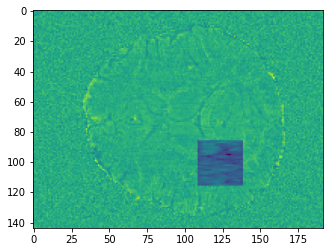

In [ ]:
prediction = segnet.predict(x=testing_volumes_T1_processed)
difference = testing_volumes_T1_processed - prediction

plt.imshow(difference[:, :, 149, 0])

In [ ]:
N_RUNS = 10
predictions = np.zeros(IMAGE_SIZE+(N_CLASSES, N_RUNS, ))
for run in range(N_RUNS) :
  predictions[..., run] = segnet.predict(x=testing_volumes_T1_processed)

mean_prediction = predictions.mean(axis=-1)
std_prediction = predictions.std(axis=-1)

5/5 [==============================] - 0s 83ms/step


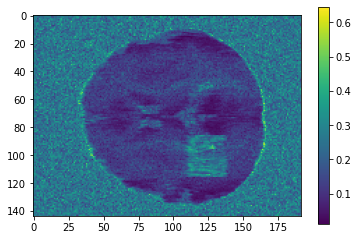

In [ ]:
plt.imshow(std_prediction[:, :, 149, 0])
plt.colorbar()